In [9]:
%pip install ipykernel numpy pandas matplotlib scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# Підготовчий етап
Провести аналіз вибраного набору даних, визначити вхідні та вихідні параметри, візуалізувати залежності входів на виходу, спробувати виявити основні залежності, детектувати аномалії, неповні зразки тощо у даних.

Дорожна карта для підготовки даних - стр. 34-35 рекомендованої книги.

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [11]:

iris = datasets.load_iris()
X = iris.data  # вхідні ознаки (4 колонки)
y = iris.target  # ціль (3 класи)

# Для демонстрації робимо простий DataFrame (зручно аналізувати / візуалізувати)
df = pd.DataFrame(X, columns=iris.feature_names)
df['target'] = y

In [12]:
# Розподіли ознак
print(df.groupby('target').mean())

# Парний графік — для Jupyter можна розкоментувати
# pd.plotting.scatter_matrix(df.iloc[:, :4], figsize=(8,8), c=df['target'], diagonal='kde')
# plt.suptitle('Pairwise feature scatter (Iris)')
# plt.show()

        sepal length (cm)  sepal width (cm)  petal length (cm)  \
target                                                           
0                   5.006             3.428              1.462   
1                   5.936             2.770              4.260   
2                   6.588             2.974              5.552   

        petal width (cm)  
target                    
0                  0.246  
1                  1.326  
2                  2.026  


In [13]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# one-hot encoding для цілей (для нашої реалізації MLP з softmax)
encoder = OneHotEncoder(sparse_output=False)
y_onehot = encoder.fit_transform(y.reshape(-1,1))

# Розділяємо на тренувальну та тестову вибірки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_onehot, test_size=0.2, random_state=42, stratify=y)


# Реалізація класифікатору
Вивчити засади роботи багатошарового персептрону та основні архітектури. Написати код класифікатору для обраного набору даних.

In [14]:
class SimpleMLP:
    def __init__(self, input_size, hidden_size, output_size, lr=0.01, seed=None):
        # Ініціалізація параметрів мережі
        # input_size: розмірність вхідного вектора
        # hidden_size: кількість нейронів у прихованому шарі
        # output_size: кількість класів
        # lr: learning rate
        if seed is not None:
            np.random.seed(seed)
        # Ініціалізуємо ваги малими випадковими числами
        self.W1 = np.random.randn(input_size, hidden_size) * 0.1  # матриця вага: вхід -> прихований
        self.b1 = np.zeros((1, hidden_size))  # зсув для прихованого шару
        self.W2 = np.random.randn(hidden_size, output_size) * 0.1  # матриця вага: прихований -> вихід
        self.b2 = np.zeros((1, output_size))  # зсув для вихідного шару
        self.lr = lr

    @staticmethod
    def relu(x):
        # ReLU активація
        return np.maximum(0, x)

    @staticmethod
    def relu_deriv(x):
        # похідна ReLU
        return (x > 0).astype(float)

    @staticmethod
    def softmax(x):
        # стабільний softmax по рядках
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)

    @staticmethod
    def cross_entropy_loss(preds, targets):
        # preds: прогноз softmax, targets: one-hot
        # повертає середню крос-ентропію
        n_samples = preds.shape[0]
        # щоб уникнути log(0)
        clipped = np.clip(preds, 1e-12, 1.0)
        loss = -np.sum(targets * np.log(clipped)) / n_samples
        return loss

    def forward(self, X):
        # Прямий прохід
        z1 = X.dot(self.W1) + self.b1  # лінійна комбінація для прихованого шару
        a1 = self.relu(z1)  # активація
        z2 = a1.dot(self.W2) + self.b2  # лінійна комбінація для виходу
        a2 = self.softmax(z2)  # softmax — ймовірності класів
        cache = {'X': X, 'z1': z1, 'a1': a1, 'z2': z2, 'a2': a2}
        return a2, cache

    def backward(self, cache, y_true):
        # Зворотне розповсюдження похибки. Повертає градієнти для ваг і зсувів
        X = cache['X']
        a1 = cache['a1']
        a2 = cache['a2']
        n = X.shape[0]

        # градієнт для зчеплення softmax + cross-entropy
        dz2 = (a2 - y_true) / n  # [batch, output]
        dW2 = a1.T.dot(dz2)  # [hidden, output]
        db2 = np.sum(dz2, axis=0, keepdims=True)  # [1, output]

        # розповсюдження в прихований шар
        da1 = dz2.dot(self.W2.T)  # [batch, hidden]
        dz1 = da1 * self.relu_deriv(cache['z1'])  # застосовуємо похідну ReLU
        dW1 = X.T.dot(dz1)  # [input, hidden]
        db1 = np.sum(dz1, axis=0, keepdims=True)

        return dW1, db1, dW2, db2

    def update_params(self, grads):
        dW1, db1, dW2, db2 = grads
        # простий градієнтний крок
        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1
        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2

    def predict_proba(self, X):
        probs, _ = self.forward(X)
        return probs

    def predict(self, X):
        probs = self.predict_proba(X)
        return np.argmax(probs, axis=1)

    def fit(self, X, y, epochs=100, batch_size=16, verbose=True):
        # X: [n_samples, input_size], y: one-hot [n_samples, output_size]
        n = X.shape[0]
        history = {'loss': []}
        for epoch in range(1, epochs+1):
            # Перемішуємо вибірку кожну епоху
            perm = np.random.permutation(n)
            X_shuffled = X[perm]
            y_shuffled = y[perm]

            epoch_loss = 0.0
            for i in range(0, n, batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]

                preds, cache = self.forward(X_batch)
                loss = self.cross_entropy_loss(preds, y_batch)
                epoch_loss += loss * X_batch.shape[0]

                grads = self.backward(cache, y_batch)
                self.update_params(grads)

            epoch_loss /= n
            history['loss'].append(epoch_loss)
            if verbose and epoch % max(1, epochs//10) == 0:
                print(f'Epoch {epoch}/{epochs} — loss: {epoch_loss:.4f}')
        return history


Epoch 20/200 — loss: 1.0251
Epoch 40/200 — loss: 0.8044
Epoch 60/200 — loss: 0.5831
Epoch 80/200 — loss: 0.4622
Epoch 100/200 — loss: 0.3869
Epoch 120/200 — loss: 0.3337
Epoch 140/200 — loss: 0.2947
Epoch 160/200 — loss: 0.2638
Epoch 180/200 — loss: 0.2385
Epoch 200/200 — loss: 0.2168


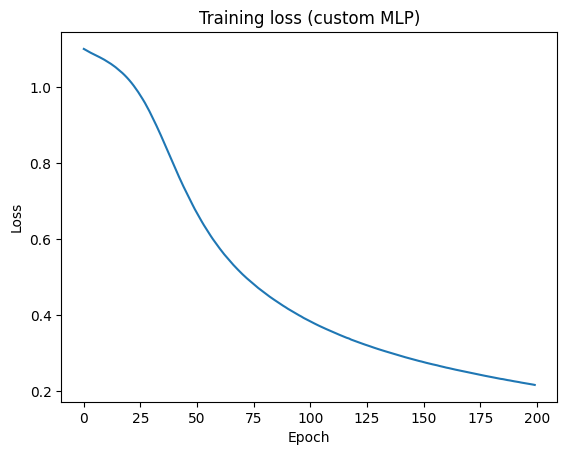

Custom MLP accuracy: 0.8666666666666667
Confusion matrix (custom):
[[10  0  0]
 [ 0  7  3]
 [ 0  1  9]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.88      0.70      0.78        10
           2       0.75      0.90      0.82        10

    accuracy                           0.87        30
   macro avg       0.88      0.87      0.87        30
weighted avg       0.88      0.87      0.87        30



In [15]:
input_size = X_train.shape[1]
hidden_size = 10 # вибір архітектури — обґрунтування: 10 — достатньо для простого датасету Iris
output_size = y_train.shape[1]


mlp_custom = SimpleMLP(input_size=input_size, hidden_size=hidden_size, output_size=output_size, lr=0.01, seed=1)
history = mlp_custom.fit(X_train, y_train, epochs=200, batch_size=16, verbose=True)


# Графік втрат
plt.plot(history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss (custom MLP)')
plt.show()


# Оцінка на тестовій вибірці
y_test_labels = np.argmax(y_test, axis=1)
preds_test = mlp_custom.predict(X_test)
print('Custom MLP accuracy:', accuracy_score(y_test_labels, preds_test))
print('Confusion matrix (custom):')
print(confusion_matrix(y_test_labels, preds_test))
print(classification_report(y_test_labels, preds_test))

In [16]:
sklearn_mlp = MLPClassifier(hidden_layer_sizes=(hidden_size,), activation='relu', solver='sgd', learning_rate_init=0.01, max_iter=500, random_state=1)
y_labels_all = np.argmax(y_onehot, axis=1)
X_train_full, X_test_full, y_train_labels, y_test_labels_single = train_test_split(X_scaled, y_labels_all, test_size=0.2, random_state=42, stratify=y)


sklearn_mlp.fit(X_train_full, y_train_labels)
sk_preds = sklearn_mlp.predict(X_test_full)
print('\nsklearn MLP accuracy:', accuracy_score(y_test_labels_single, sk_preds))
print('Confusion matrix (sklearn):')
print(confusion_matrix(y_test_labels_single, sk_preds))
print(classification_report(y_test_labels_single, sk_preds))


sklearn MLP accuracy: 0.9333333333333333
Confusion matrix (sklearn):
[[10  0  0]
 [ 0  9  1]
 [ 0  1  9]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.90      0.90      0.90        10
           2       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



# Аналіз результатів
1. Пояснити кожен рядок коду (за запитом викладача)
2. Вибір кількості шарів, обгрунтування архітектури
3. Оцінка помилок на начальній та тестовій вибірках
4. Результати оформити протоколом

In [17]:
results = pd.DataFrame({
'model': ['custom_mlp', 'sklearn_mlp'],
'accuracy': [accuracy_score(y_test_labels, preds_test), accuracy_score(y_test_labels_single, sk_preds)]
})
results

,model,accuracy
0,custom_mlp,0.866667
1,sklearn_mlp,0.933333


# Контрольні питання
1. **Що таке MLP?**

    MLP (Multi-Layer Perceptron) — це клас штучних нейронних мереж повного зв'язку, що складаються з вхідного шару, одного або більше прихованих шарів і вихідного шару. Кожний нейрон виконує лінійну комбінацію вхідних значень з вагами + зсув, потім застосовує нелінійну функцію активації. MLP навчається методом зворотного розповсюдження (backpropagation) з оптимізатором (наприклад, SGD, Adam).

2. **Яке призначення прихованого шару?**

    Прихований шар дозволяє мережі вивчати нелінійні відношення між входом і виходом. Лінійна модель (без прихованих шарів) може апроксимувати лише лінійні функції; додавання прихованих шарів і нелінійних активацій дозволяє моделі будувати більш складні, багаторівневі представлення (feature learning), що значно розширює клас функцій, які мережа може навчитися апроксимувати.